In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp2d,interpn,interp1d,RectBivariateSpline

### Air Source Heat Pump Experimentation
The goal of this notebook is to model the heating energy usage of a building throughout an average winter, and understand how an air source heat pump would operate in this environment.

1. In this notebook we build up weather bin data over a 40 year history in New Rochelle NY.
2. Given the building design parameters (gleaned from a Manual-J report), we estimate the distribution of building loads over air temperature.
3. We also model the performance, in terms of capacity and output of the upcoming SpacePak SIS-060A inverter driven split system.

### Load 1 hour weather bars

In [2]:
weather = pd.read_csv('./data/b68ae80c504c3736013cee0375a19681.csv')
weather['timestamp']=pd.to_datetime(weather['dt']*1000000000.0).dt.tz_localize('utc').dt.tz_convert('America/New_York')
weather['date']=weather['timestamp'].dt.date
weather['year']=weather['timestamp'].dt.year
weather['month']=weather['timestamp'].dt.month
weather['time']=weather['timestamp'].dt.time
weather['month_cat']=weather['month'].astype('category')
weather=weather.query('year<2020').copy()
weather=weather.merge(weather.groupby('date')['temp'].min().to_frame('min_daily_temp'), on='date')
weather=weather.merge(weather.groupby('date')['temp'].max().to_frame('max_daily_temp'), on='date')
weather['outside_temp']=weather['temp'].round()
weather['is_heating_day']=1.0*((weather['min_daily_temp']<50)&(~weather['month'].isin([6,7,8,9]))&(weather['max_daily_temp']<71))
weather['is_cooling_day']=1.0*((1.0-weather['is_heating_day']).astype(bool)&(weather['month'].isin([6,7,8,9]))&(weather['min_daily_temp']>50))

heating_day = weather.query('is_heating_day==1.0').copy()
cooling_day = weather.query('is_cooling_day==1.0').copy()


### View of the weather data

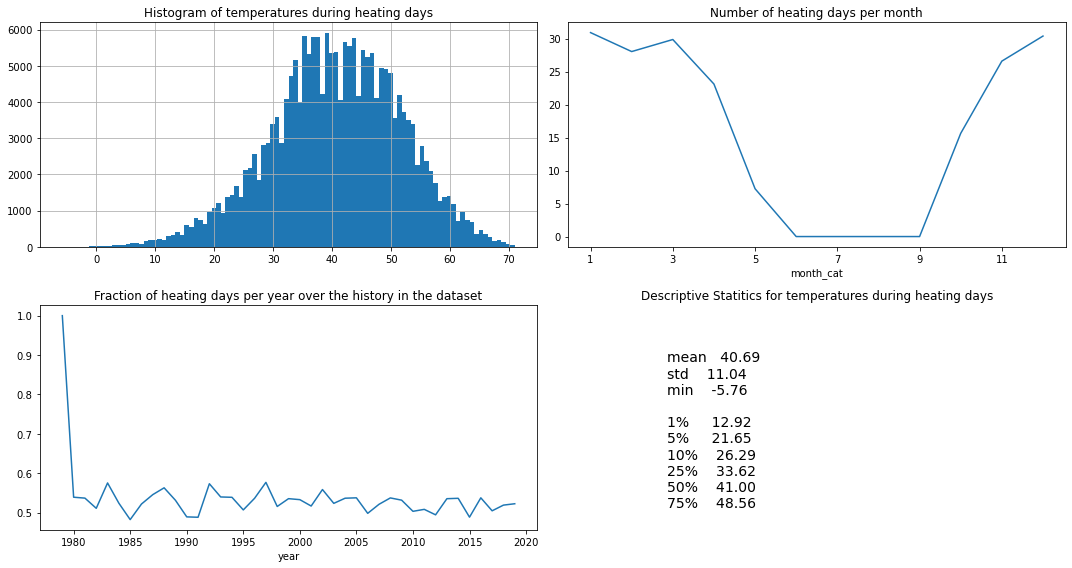

In [3]:
fig,axes=plt.subplots(2,2,figsize=(15,8))
axes=axes.reshape(-1)
heating_day['temp'].hist(bins=100,ax=axes[0])
axes[0].set_title('Histogram of temperatures during heating days')
axes[1].set_title('Number of heating days per month')
(heating_day.drop_duplicates(subset=['date']).groupby('month_cat')['date'].nunique()/40.0).plot(ax=axes[1])
axes[2].set_title('Fraction of heating days per year over the history in the dataset')
weather.groupby('year')['is_heating_day'].mean().plot(ax=axes[2])
desc=heating_day['temp'].describe(percentiles=[.01,.05,.10,.25,.50,.75])[['mean', 'std', 'min', '1%', '5%', '10%', '25%', '50%', '75%']]
_= axes[3].text(.20,.1,desc.to_string(float_format='%.2f').replace('\n','\n\n',3).replace('\n\n','\n',2),fontsize=14)
axes[3].get_xaxis().set_visible(False)
axes[3].get_yaxis().set_visible(False)
_ = axes[3].axis('off')
_ = axes[3].set_title('Descriptive Statitics for temperatures during heating days')
fig.tight_layout()

### Cooling Days

### Build the design conditions

In [12]:
design_load=60000 # BTUS/hr
design_outdoor_temp=int(desc['1%']) # ~13 Degrees
design_indoor_temp=70 #degree F
design_supply_temp=110 #degree F
design_dt=design_indoor_temp-design_outdoor_temp #difference between indoor and outdoor on "coldest" hour of the year

#### Build the temperature bin data.

In [13]:
bin_data=heating_day.groupby(['year','outside_temp'])['dt'].nunique().unstack(0).fillna(0).mean(axis=1).to_frame('num_hours').reset_index()

In [14]:
#Current design delta-t
bin_data['dt']=(design_indoor_temp-bin_data['outside_temp'])
#Fraction of the design load
bin_data['pct_of_design_load']=(bin_data['dt'])/design_dt
# Load at this outdoor temp
bin_data['load']=bin_data['pct_of_design_load']*design_load
# Ignore scenarios below or above design conditions
bin_data=bin_data.query('(pct_of_design_load>=0)&(pct_of_design_load<=1)').copy()
#Number of hours at or above the current load and by %
bin_data['num_hours_at_or_above_load']=bin_data.sort_values(by='pct_of_design_load',ascending=False)['num_hours'].cumsum()
bin_data['pct_time_at_or_above_load']=bin_data['num_hours_at_or_above_load']/(bin_data['num_hours_at_or_above_load'].max())

#Building load function
building_load = lambda outside_temp: ((design_indoor_temp-outside_temp)/design_dt)*design_load

#Supply Water temperature as a function of load and design max temp, max temp setting requires 
# consulting radiator design/manual-J
swt_slope=(design_supply_temp-design_indoor_temp)/design_dt
swt = lambda x: swt_slope*(design_indoor_temp-x) + design_indoor_temp
swt_intercept=swt(0)

#from SWT -> outdoor temp
swtinv = lambda swt: (design_indoor_temp-swt)*design_dt/(design_supply_temp-design_indoor_temp) + design_indoor_temp

#SSI Capacity and COP courtesy of John Seigenthaler
bin_data['SWT']=bin_data['outside_temp'].apply(swt)
b1 = lambda ts: .047865-.000259098*ts
b2 = lambda ts: 5.505128e-5 - 9.0026e-7*ts + (3.9629e-9)*ts**2
COP = lambda tout: (4.82-.026*swt(tout)) + b1(swt(tout))*tout + b2(swt(tout))*tout**2
q = lambda tout: (56518-100.6385*swt(tout))  + (709.32-1.26291*swt(tout))*tout
bin_data['SSI_output']=bin_data[['SWT','outside_temp']].apply(lambda row: min(q(row['outside_temp']),65000),axis=1)
bin_data['SSI_COP']=bin_data[['SWT','outside_temp']].apply(lambda row: min(COP(row['outside_temp']),4.5),axis=1)

#Automatically compute the balance point where SSI output matches the building load
fmin = lambda x: np.abs(q(x)-building_load(x))
res=minimize_scalar(fmin,bounds=(0,design_indoor_temp), method='bounded')
balance_point=res.x
print(res)

     fun: 0.0018474540920578875
 message: 'Solution found.'
    nfev: 21
  status: 0
 success: True
       x: 16.564081342671507


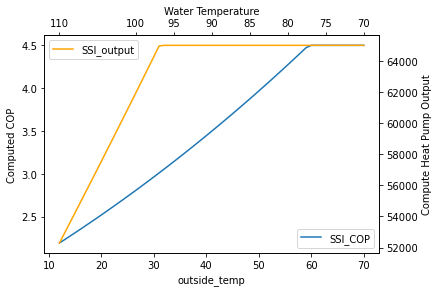

In [15]:
ax=bin_data.set_index('outside_temp')[['SSI_COP']].plot()
ax.legend(loc=4)
ax.set_ylabel('Computed COP')
ax=bin_data.set_index('outside_temp')[['SSI_output']].plot(ax=ax.twinx(),color='orange')
ax.set_ylabel('Compute Heat Pump Output')
plt.locator_params(nbins=10)
new_ax=ax.secondary_xaxis('top', functions=(swt,swtinv))
new_ax.set_xlabel('Water Temperature')
_=new_ax.set_xticks((154,140,130,120,110,100,95,90,85,80,75,70))

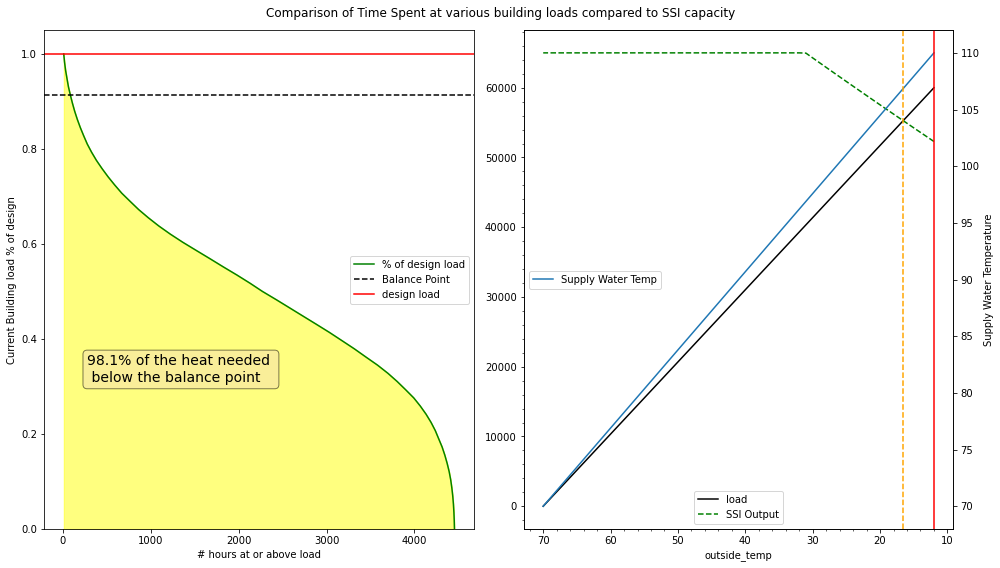

In [33]:
fig,axes=plt.subplots(1,2,figsize=(14,8))
axes=axes.reshape(-1)
ax=axes[0]
plt.minorticks_on()
bin_data.plot.area(x='num_hours_at_or_above_load',y='pct_of_design_load',color='yellow',alpha=0.5,ax=ax,label='')
bin_data.plot(x='num_hours_at_or_above_load',y='pct_of_design_load',label='% of design load',ax=ax,color='green')
ax.set_xlabel('# hours at or above load')
ax.set_ylabel('Current Building load % of design')

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
balance_idx=(bin_data['outside_temp']-balance_point).abs().argmin()
bp_bin=bin_data.iloc[balance_idx]
ax.axhline(bp_bin['pct_of_design_load'].item(),ls='--',color='black',label='Balance Point')
below_balance=100*(1-bp_bin['pct_time_at_or_above_load'].item())
ax.axhline(1.0,color='r',label='design load')
# place a text box in upper left in axes coords
_ = ax.text(0.1, .35, f'{below_balance:.01f}% of the heat needed \n below the balance point', 
             transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
ax.legend(loc=5)

ax=axes[1]
bin_data.plot(x='outside_temp',y='load',color='black',ax=ax)
ax.invert_xaxis()
ax1=ax.twinx()
ax1.set_ylabel('Building Load')
bin_data.plot(x='outside_temp',y='SWT',ax=ax1, label='Supply Water Temp')
ax1.set_ylabel('Supply Water Temperature')
ax1.axvline(design_outdoor_temp,color='r')
bin_data.plot(x='outside_temp',y='SSI_output',ax=ax,style='--',color='g', label='SSI Output')
ax.legend(loc=8)
ax1.legend(loc=6)
fig.suptitle('', fontsize=12,y=1.1)
ax1.axvline(balance_point,color='orange',ls='--')
fig.suptitle('Comparison of Time Spent at various building loads compared to SSI capacity')
fig.tight_layout()

In [34]:
np.average(bin_data['SSI_COP'], 
           weights=bin_data['num_hours'])

3.5095050890293438

In [35]:
bin_data['btus_in_bin']=bin_data['load']*bin_data['num_hours']
bin_data['kwh_in_bin']=(bin_data['btus_in_bin']*0.000293071)
bin_data['kwh_required']=(bin_data['kwh_in_bin']/bin_data['SSI_COP'])
bin_data['therms_in_bin']=(bin_data['btus_in_bin']/99976)

In [36]:
def custom_round(x, base=5):
    return int(base * round(float(x)/base))
bin_data['round_outside_temp']=bin_data['outside_temp'].apply(custom_round)
bin_data['round_ssi_cop']=(10*bin_data['SSI_COP']).apply(custom_round)/10

<AxesSubplot:xlabel='round_outside_temp'>

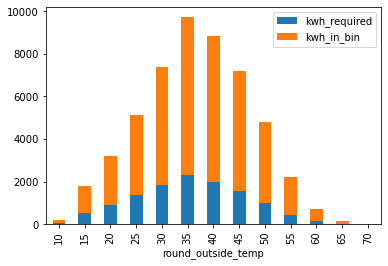

In [37]:
bin_data.groupby('round_outside_temp')[['kwh_required','kwh_in_bin']].sum().plot.bar(stacked=True)

<AxesSubplot:xlabel='round_ssi_cop'>

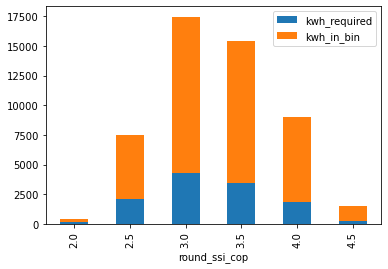

In [42]:
bin_data.groupby('round_ssi_cop')[['kwh_required','kwh_in_bin']].sum().plot.bar(stacked=True)

In [43]:
bin_data['above_balance']=(bin_data['outside_temp']>=balance_point)

In [44]:
energy_del_vs_required = bin_data.groupby('above_balance')[['kwh_in_bin','kwh_required']].sum()
energy_del_vs_required

,kwh_in_bin,kwh_required
above_balance,,
False,1036.169898,453.384773
True,38210.877973,11679.477371


### Serious reductions of total energy needed from the energy grid.
### 67% reduction above the balance point.
### 50% reduction below it

In [45]:
100*(1-energy_del_vs_required['kwh_required']/energy_del_vs_required['kwh_in_bin'])

above_balance
False    56.244167
True     69.434156
dtype: float64

### Remaining fraction of total energy from supplemental heat source.

In [46]:
supplemental=100*(energy_del_vs_required['kwh_in_bin'][False]/(energy_del_vs_required['kwh_in_bin'][False]+energy_del_vs_required['kwh_in_bin'][True]))
f'{round(supplemental,2)}% from supplemental heat source'

'2.64% from supplemental heat source'

### Total % reduction in energy from grid

In [47]:
from_grid=100*(energy_del_vs_required['kwh_required'].sum()/energy_del_vs_required['kwh_in_bin'].sum())
f'{round(from_grid,2)}% electricity from grid'

'30.91% electricity from grid'

### Cost Savings % including dollars

In [48]:
round(100*(1-round((energy_del_vs_required['kwh_required'].sum())*.25,2)/round((energy_del_vs_required['kwh_in_bin'].sum()/(.9*29.3001))*2.50,2)),2)

18.48

### Cost Savings % including dollars

In [49]:
round(100*(1-((energy_del_vs_required['kwh_required'].sum()-2000)*.25)/(energy_del_vs_required['kwh_in_bin'].sum()/((.8*29.3001))*2.50)),2)

39.48

### # of hours at each COP above the balance point

<AxesSubplot:xlabel='round_ssi_cop'>

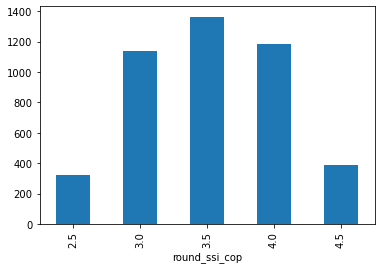

In [50]:
bin_data.query('outside_temp>=@balance_point').groupby('round_ssi_cop')['num_hours'].sum().plot.bar()

<AxesSubplot:xlabel='round_ssi_cop'>

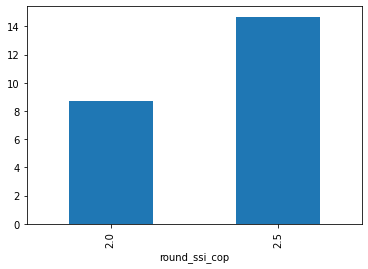

In [51]:
bin_data.query('outside_temp<@balance_point').groupby('round_ssi_cop')['num_hours'].mean().plot.bar()